In [1]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import MT5TokenizerFast
import json
import pandas as pd
from data_utils.utils import *
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from torch.utils.data import DataLoader

/home/nlp/anaconda3/envs/vietnq-ner/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_LENGTH = 1024
model_name = 'google/mt5-base'
tokenizer = MT5TokenizerFast.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/nlp/anaconda3/envs/vietnq-ner/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Dataset: ViSquad v1.1

In [3]:
visquad_ds_json = {}

with open('datasets/ViSquadv1.1/train_ViQuAD.json') as f:
    visquad_ds_json['train'] = json.load(f)
with open('datasets/ViSquadv1.1/dev_ViQuAD.json') as f:
    visquad_ds_json['dev'] = json.load(f)
with open('datasets/ViSquadv1.1/test_ViQuAD.json') as f:
    visquad_ds_json['test'] = json.load(f)

len(visquad_ds_json['train']['data']), len(visquad_ds_json['dev']['data']), len(visquad_ds_json['test']['data'])

(138, 18, 18)

In [4]:
ds_dict = {
    'instruction': [],
    'input': [],
    'answer': [], 
    'split': []
}

for split_name, split_ds in visquad_ds_json.items():
    for data_topic in split_ds['data']:
        for data_para in data_topic['paragraphs']:
            text = data_para['context']
            for qa in data_para['qas']:
                question = qa['question']
                answer = qa['answers'][0]['text']
                ds_dict['input'].append(text)
                ds_dict['instruction'].append(question)
                ds_dict['answer'].append(answer)
                ds_dict['split'].append(split_name)

In [5]:
df = pd.DataFrame(ds_dict)
df

,instruction,input,answer,split
0,Tên gọi nào được Phạm Văn Đồng sử dụng khi làm...,Phạm Văn Đồng (1 tháng 3 năm 1906 – 29 tháng 4...,Lâm Bá Kiệt,train
1,Phạm Văn Đồng giữ chức vụ gì trong bộ máy Nhà ...,Phạm Văn Đồng (1 tháng 3 năm 1906 – 29 tháng 4...,Thủ tướng,train
2,"Giai đoạn năm 1955-1976, Phạm Văn Đồng nắm giữ...",Phạm Văn Đồng (1 tháng 3 năm 1906 – 29 tháng 4...,Thủ tướng Chính phủ Việt Nam Dân chủ Cộng hòa,train
3,Sự kiện quan trọng nào đã diễn ra vào ngày 20/...,"Năm 1954, ông được giao nhiệm vụ Trưởng phái đ...","bản Hiệp định đình chỉ chiến sự ở Việt Nam, Ca...",train
4,Chức vụ mà Phạm Văn Đồng đảm nhiệm tại Hội ngh...,"Năm 1954, ông được giao nhiệm vụ Trưởng phái đ...",Trưởng phái đoàn Chính phủ,train
...,...,...,...,...
23069,Nếu những yêu cầu mà bộ nhớ Squid không thể th...,Các yêu cầu trang được gửi cho tầng máy Squid ...,được gửi qua các máy chủ cân bằng tải (load-ba...,test
23070,Cần làm gì để tăng tốc độ trả lời cho người ch...,Các yêu cầu trang được gửi cho tầng máy Squid ...,các trang được kết xuất cho người chưa đăng nh...,test
23071,Các máy chủ cân bằng tải gửi yêu cầu cho máy c...,Các yêu cầu trang được gửi cho tầng máy Squid ...,kết xuất trang dùng dữ liệu từ CSDL,test
23072,Để giải quyết các yêu cầu thì máy chủ web có n...,Các yêu cầu trang được gửi cho tầng máy Squid ...,gửi lại những trang được yêu cầu và kết xuất t...,test


In [6]:
# create new column in df that measure number of tokens in input and instruction and answer
df['input_len'] = df['input'].apply(lambda x: len(tokenizer(x)['input_ids']))
df['instruction_len'] = df['instruction'].apply(lambda x: len(tokenizer(x)['input_ids']))
df['answer_len'] = df['answer'].apply(lambda x: len(tokenizer(x)['input_ids']))

In [7]:
df.describe()

,input_len,instruction_len,answer_len
count,23074.000000,23074.000000,23074.000000
mean,387.504681,31.839430,22.476554
std,152.812110,10.366111,23.381766
min,181.000000,4.000000,2.000000
25%,285.000000,24.000000,6.000000
50%,347.000000,31.000000,14.000000
75%,444.000000,38.000000,30.750000
max,3318.000000,108.000000,360.000000


In [8]:
# only get those has context length less than 512 tokens
df = df[df['input_len'] < 512]
df

,instruction,input,answer,split,input_len,instruction_len,answer_len
0,Tên gọi nào được Phạm Văn Đồng sử dụng khi làm...,Phạm Văn Đồng (1 tháng 3 năm 1906 – 29 tháng 4...,Lâm Bá Kiệt,train,295,53,6
1,Phạm Văn Đồng giữ chức vụ gì trong bộ máy Nhà ...,Phạm Văn Đồng (1 tháng 3 năm 1906 – 29 tháng 4...,Thủ tướng,train,295,43,6
2,"Giai đoạn năm 1955-1976, Phạm Văn Đồng nắm giữ...",Phạm Văn Đồng (1 tháng 3 năm 1906 – 29 tháng 4...,Thủ tướng Chính phủ Việt Nam Dân chủ Cộng hòa,train,295,33,21
3,Sự kiện quan trọng nào đã diễn ra vào ngày 20/...,"Năm 1954, ông được giao nhiệm vụ Trưởng phái đ...","bản Hiệp định đình chỉ chiến sự ở Việt Nam, Ca...",train,235,24,70
4,Chức vụ mà Phạm Văn Đồng đảm nhiệm tại Hội ngh...,"Năm 1954, ông được giao nhiệm vụ Trưởng phái đ...",Trưởng phái đoàn Chính phủ,train,235,35,11
...,...,...,...,...,...,...,...
23069,Nếu những yêu cầu mà bộ nhớ Squid không thể th...,Các yêu cầu trang được gửi cho tầng máy Squid ...,được gửi qua các máy chủ cân bằng tải (load-ba...,test,333,44,38
23070,Cần làm gì để tăng tốc độ trả lời cho người ch...,Các yêu cầu trang được gửi cho tầng máy Squid ...,các trang được kết xuất cho người chưa đăng nh...,test,333,34,40
23071,Các máy chủ cân bằng tải gửi yêu cầu cho máy c...,Các yêu cầu trang được gửi cho tầng máy Squid ...,kết xuất trang dùng dữ liệu từ CSDL,test,333,39,18
23072,Để giải quyết các yêu cầu thì máy chủ web có n...,Các yêu cầu trang được gửi cho tầng máy Squid ...,gửi lại những trang được yêu cầu và kết xuất t...,test,333,31,39


In [9]:
df.loc[:, 'prompt'] = df.apply(prompt_input, axis=1)

/tmp/ipykernel_2706835/1894269207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'prompt'] = df.apply(prompt_input, axis=1)


In [10]:
df['prompt_len'] = df['prompt'].apply(lambda x: len(tokenizer(x)['input_ids']))
df.describe()

/tmp/ipykernel_2706835/442272497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prompt_len'] = df['prompt'].apply(lambda x: len(tokenizer(x)['input_ids']))


,input_len,instruction_len,answer_len,prompt_len
count,19608.000000,19608.000000,19608.000000,19608.000000
mean,339.357711,31.648664,21.623164,423.006375
std,75.354180,10.330319,22.233965,76.576828
min,181.000000,5.000000,2.000000,246.000000
25%,277.000000,24.000000,6.000000,360.000000
50%,327.000000,30.000000,13.000000,411.000000
75%,397.000000,38.000000,30.000000,481.000000
max,511.000000,108.000000,360.000000,633.000000


In [11]:
dataset_instruct = Dataset.from_pandas(df[['prompt', 'answer']], preserve_index=False)
dataset_instruct

Dataset({
    features: ['prompt', 'answer'],
    num_rows: 19608
})

In [12]:
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
dataset_tokenized = dataset_instruct.map(
    lambda x: tokenize(x, tokenizer, "prompt", "answer"),
    batched=True,
    remove_columns=["prompt", "answer"],
)

print(">> Dataset is ready:")
print(dataset_tokenized)

> Tokenizing dataset...


Map: 100%|██████████| 19608/19608 [00:03<00:00, 5446.67 examples/s]

>> Dataset is ready:
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 19608
})


In [14]:
print(
    tokenizer.decode(dataset_tokenized[0]['input_ids'], skip_special_tokens=False)
)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: Tên gọi nào được Phạm Văn Đồng sử dụng khi làm Phó chủ nhiệm cơ quan Biện sự xứ tại Quế Lâm? ### Input: Phạm Văn Đồng (1 tháng 3 năm 1906 – 29 tháng 4 năm 2000) là Thủ tướng đầu tiên của nước Cộng hòa Xã hội chủ nghĩa Việt Nam từ năm 1976 (từ năm 1981 gọi là Chủ tịch Hội đồng Bộ trưởng) cho đến khi nghỉ hưu năm 1987. Trước đó ông từng giữ chức vụ Thủ tướng Chính phủ Việt Nam Dân chủ Cộng hòa từ năm 1955 đến năm 1976. Ông là vị Thủ tướng Việt Nam tại vị lâu nhất (1955–1987). Ông là học trò, cộng sự của Chủ tịch Hồ Chí Minh. Ông có tên gọi thân mật là Tô, đây từng là bí danh của ông. Ông còn có tên gọi là Lâm Bá Kiệt khi làm Phó chủ nhiệm cơ quan Biện sự xứ tại Quế Lâm (Chủ nhiệm là Hồ Học Lãm). ### Response:</s>


In [15]:
print(
    tokenizer.decode(dataset_tokenized[0]['labels'], skip_special_tokens=False)
)

Lâm Bá Kiệt</s>


In [16]:
output_repo = 'vi-mT5-QA-ViQuAD_v1.1'
print(f"> Pushing to hub: {output_repo}")
dataset_tokenized.push_to_hub(output_repo)

> Pushing to hub: vi-mT5-QA-ViQuAD_v1.1


Uploading the dataset shards: 100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/vi-mT5-QA-ViQuAD_v1.1/commit/1eb66561822bd0225853c79706adba917dfefe13', commit_message='Upload dataset', commit_description='', oid='1eb66561822bd0225853c79706adba917dfefe13', pr_url=None, pr_revision=None, pr_num=None)

## Dataset: VinAI_PhoMT

In [32]:
output_repo = 'en-vi-mT5-MT'

In [17]:
corpus = load_dataset('wanhin/VinAI_PhoMT', split='train', streaming=True)
corpus = corpus.take(136_000)
phomt_ds = Dataset.from_generator(
    lambda: (yield from corpus),
    features=corpus.features
)
phomt_ds

Dataset({
    features: ['en', 'vi'],
    num_rows: 136000
})

In [20]:
def make_instruction_data(samples):
    prompts, answers = [], []

    for sample_en, sample_vi in zip(samples['en'], samples['vi']):
        prompts.append(prompt_input({
            'instruction': 'Translate the following English sentence to Vietnamese',
            'input': sample_en
        }))
        answers.append(sample_vi)

    return {
        'prompt': prompts,
        'answer': answers
    }

print("> Making instruction dataset...")
en_vi_mt_instruct = phomt_ds.map(
    make_instruction_data, batched=True, remove_columns=phomt_ds.column_names
)
print("Instruction dataset:", en_vi_mt_instruct)

> Making instruction dataset...


Map: 100%|██████████| 136000/136000 [00:01<00:00, 127942.04 examples/s]

Instruction dataset: Dataset({
    features: ['prompt', 'answer'],
    num_rows: 136000
})


In [22]:
df = en_vi_mt_instruct.to_pandas()
df

,prompt,answer
0,"Below is an instruction that describes a task,...",Câu chuyện bắt đầu với buổi lễ đếm ngược.\n
1,"Below is an instruction that describes a task,...","Ngày 14, tháng 8, năm 1947, gần nửa đêm, ở Bom..."
2,"Below is an instruction that describes a task,...","Cùng lúc, trên khắp đất Ấn, người ta nín thở c..."
3,"Below is an instruction that describes a task,...","Khi đồng hồ điểm thời khắc nửa đêm, một đứa tr..."
4,"Below is an instruction that describes a task,...","Những sự kiện này là nền móng tạo nên ""Những đ..."
...,...,...
135995,"Below is an instruction that describes a task,...",Mọi thứ nó cần là các mục tiêu của bạn và các ...
135996,"Below is an instruction that describes a task,...",Tôi sẽ cho một ví dụ.\n
135997,"Below is an instruction that describes a task,...",Lấy trường hợp về khung máy bay không người lá...
135998,"Below is an instruction that describes a task,...",Máy tính sẽ tìm và đưa ra toàn bộ không gian g...


#### Convey the lengths of samples in dataset

Map: 100%|██████████| 136000/136000 [00:06<00:00, 21383.94 examples/s]


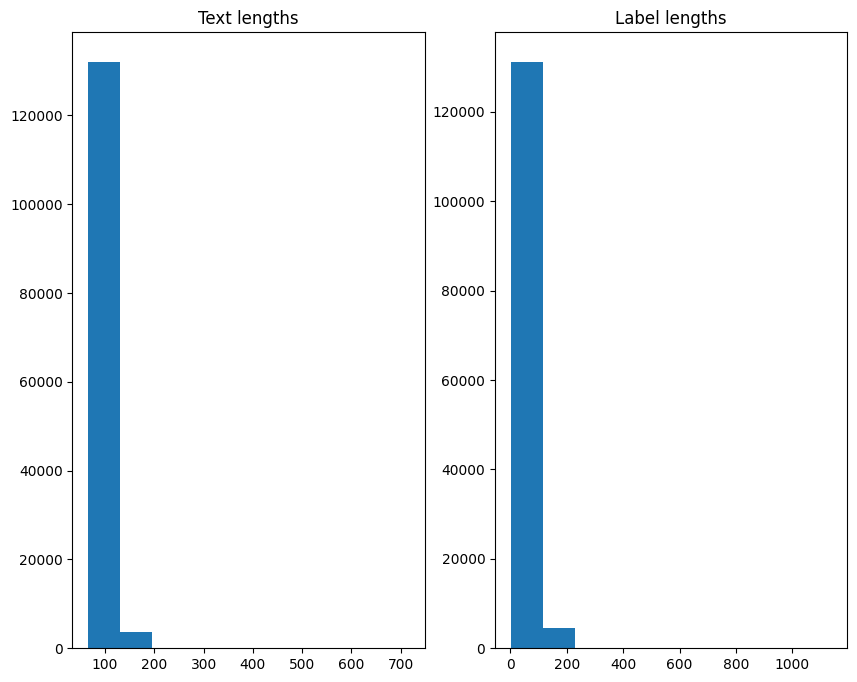

Max text length: 716
Max label length: 1138
Current limit: MAX_LENGTH = 1024


In [25]:
en_vi_mt_instruct_with_length = en_vi_mt_instruct.map(
    lambda samples: {
        'len_text': [len(x) for x in tokenizer(samples['prompt'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
        'len_label': [len(x) for x in tokenizer(samples['answer'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
    },
    batched=True
)

text_lengths = en_vi_mt_instruct_with_length['len_text']
label_lengths = en_vi_mt_instruct_with_length['len_label']

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(text_lengths)
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(label_lengths)
plt.title('Label lengths')

plt.show()

print('Max text length:', max(text_lengths))
print('Max label length:', max(label_lengths))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

Drop those samples that having lengths exceed the pre-defined MAX LENGTH

In [26]:
en_vi_mt_instruct_with_length_dropped = en_vi_mt_instruct_with_length.filter(
    lambda example: (example['len_text'] <= MAX_LENGTH) and (example['len_label'] <= MAX_LENGTH)
)

Filter: 100%|██████████| 136000/136000 [00:00<00:00, 326044.53 examples/s]


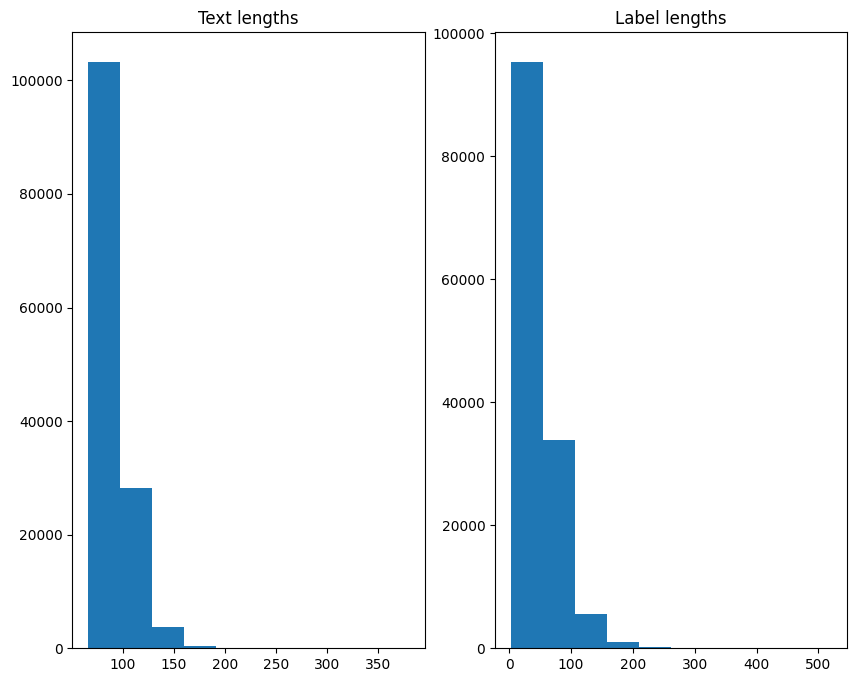

Max text length: 380
Max label length: 521
Current limit: MAX_LENGTH = 1024


In [27]:
text_lengths = en_vi_mt_instruct_with_length_dropped['len_text']
label_lengths = en_vi_mt_instruct_with_length_dropped['len_label']

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(text_lengths)
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(label_lengths)
plt.title('Label lengths')

plt.show()

print('Max text length:', max(text_lengths))
print('Max label length:', max(label_lengths))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

In [28]:
en_vi_mt_instruct_with_length_dropped

Dataset({
    features: ['prompt', 'answer', 'len_text', 'len_label'],
    num_rows: 135999
})

#### Create tokenized dataset

In [29]:
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
en_vi_mt_tokenized = en_vi_mt_instruct_with_length_dropped.map(
    lambda x: tokenize(x, tokenizer, "prompt", "answer"),
    batched=True,
    remove_columns=en_vi_mt_instruct_with_length_dropped.column_names,
)

print(">> Dataset is ready:")
print(en_vi_mt_tokenized)

> Tokenizing dataset...


Map: 100%|██████████| 135999/135999 [00:10<00:00, 13187.57 examples/s]

>> Dataset is ready:
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 135999
})


In [30]:
tokenizer.decode(en_vi_mt_tokenized[19]['input_ids'])

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: Translate the following English sentence to Vietnamese ### Input: Rushdie, who like Saleem was born in 1947, was educated in India and Britain, and is renowned for his cross - continental histories, political commentary, and magical realism. ### Response:</s>'

In [31]:
tokenizer.decode(en_vi_mt_tokenized[19]['labels'])

'Rushdie, giống như Saleem, sinh năm 1947, học tại Ấn Độ và Anh quốc, nổi tiếng nhờ vào tiểu sử xuyên lục địa, những bình luận chính trị và chủ nghĩa hiện thực huyền ảo.</s>'

#### Push to hub

In [33]:
print(f"> Pushing to hub: {output_repo}")
en_vi_mt_tokenized.push_to_hub(output_repo)

> Pushing to hub: en-vi-mT5-MT


Uploading the dataset shards: 100%|██████████| 1/1 [00:05<00:00,  5.86s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/en-vi-mT5-MT/commit/13310f7901ef173f8c3f52c38f7019f5a99bd584', commit_message='Upload dataset', commit_description='', oid='13310f7901ef173f8c3f52c38f7019f5a99bd584', pr_url=None, pr_revision=None, pr_num=None)

## Pretraining data

In [3]:
args = OmegaConf.create({
    "dataset": {
        "path": "bkai-foundation-models/BKAINewsCorpus",
        # "name": None,
        "split": "train",
        "remove_columns": ['id', 'link', 'publish'],
        "n_samples": 10000,
    },
    "data": {
        # "input_length": 1024,
        "input_length": 920,
        "mlm_probability": 0.15,
        "mean_noise_span_length": 3.0,
    },
    "optim": {
        "batch_size": 8,
        "grad_acc": 16,
        "epochs": 3,
    },
    "seed": 42,
    "is_shuffle": False
})



##### Download dataset `bkai-foundation-models/BKAINewsCorpus`

In [4]:
vi_corpus_stream = load_dataset(args.dataset.path, split=args.dataset.split, streaming=True)
vi_corpus_stream = vi_corpus_stream.take(10000)
vi_corpus = Dataset.from_generator(
    lambda: (yield from vi_corpus_stream),
    features=vi_corpus_stream.features,
)
vi_corpus = vi_corpus.remove_columns(args.dataset.remove_columns)
vi_corpus

Dataset({
    features: ['text'],
    num_rows: 10000
})

In [5]:
processed_dataset = process_pretraining_dataset(vi_corpus, args, tokenizer)
processed_dataset

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map: 100%|██████████| 10000/10000 [00:04<00:00, 2296.98 examples/s]


Dataset({
    features: ['input_ids'],
    num_rows: 14851
})

In [6]:
tokenizer.decode(processed_dataset[0]['input_ids'])

'ức tốt đẹp của thế hệ 7x, 8x, và 9x đời đầu. Đến đấy thì rất là thích vì như tìm lại kỷ niệm ấy chứ không hẳn phải mua đồ...” - Chị khách hàng của một cửa hàng văn phòng phẩm trên đường Quán Thánh đã vui vẻ chia sẻ về thói quen thú vị này khiến tôi thấy ấn tượng. Chợt nhận ra đúng là bây giờ phần lớn học sinh, trẻ con đều được ba mẹ đưa vào các cửa hàng, nhà sách hiện đại, nhiều thứ hấp dẫn trong các khu trung tâm sầm uất để mua sắm đồ dùng học tập, kết hợp vui chơi chứ không còn nhiều người chọn tìm đến những tiệm văn phòng phẩm kiểu cũ nữa. Tiệm văn phòng phẩm kiểu cũ trên phố Hàm Long Đó là những tiệm hàng nhỏ nhỏ ngay mặt tiền các con phố cũ rất đẹp, gần các trường học lâu đời và nổi tiếng của Hà Nội như phố Hàm Long, Quán Thánh... Cộng đồng dân cư sinh sống trên con phố này phần lớn cũng là những người đã sinh sống lâu đời Hà Nội, từ sau năm 1945 hoặc 1975 nên những cửa tiệm văn phòng phẩm kiểu cũ còn tồn tại được đến bây giờ và duy trì được nếp phong cách gần như không có nhiều 

In [7]:
data_collator = DataCollatorForT5MLM(
    tokenizer=tokenizer,
    noise_density=args.data.mlm_probability,
    mean_noise_span_length=args.data.mean_noise_span_length,
    input_length=args.data.input_length,
    target_length=args.data.target_length,
    pad_token_id=tokenizer.pad_token_id,
)

In [8]:
dataloader = DataLoader(
    processed_dataset,
    collate_fn=data_collator,
    batch_size=args.optim.batch_size,
    pin_memory=True,
    drop_last=False,
)

In [9]:
data_list = []

for batch in dataloader:
    inputs, labels = batch["input_ids"], batch["labels"]
    for input_item, label_item in zip(inputs, labels):
        data_list.append({"input_ids": input_item, "labels": label_item})

dataset = Dataset.from_list(data_list)
dataset

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 14851
})

In [15]:
len(dataset[12420]['input_ids']), len(dataset[12420]['labels'])

(920, 1022)

In [16]:
tokenizer.decode(dataset[12420]['input_ids'])

'úc Phương. Cụ thể, trong vụ việc trong vụ việc <extra_id_0>ứ <extra_id_1>ơn 100 cá thể tê tê tại Quảng Ninh, trước khi cơ quan chức năng tỉnh Quảng Ninh gọi điện cho WCS Việt Nam đề nghị <extra_id_2>ì số tê tê nói trên đã được thu giữ trước đ <extra_id_3> nhiều tiếng đồng hồ. Khi được thu <extra_id_4>ữ, sức khỏe số tê tê này có thể đã rất  <extra_id_5> chú <extra_id_6> vận chuyển qua những chặng đường <extra_id_7> được dấu kín trong các thùng và bao tải xếp trên xe <extra_id_8> tiết lại nóng bức nên hầu hết số tê tê này đã không thể s <extra_id_9> an bàn giao cho kiểm lâm <extra_id_10>và thời <extra_id_11> đợi được cứu hộ. Theo anh Hải, khi thu gi <extra_id_12>ng vật hoang dã,  <extra_id_13>ùy vào chủng loại các loài thú, các cơ quan chức năng cần đánh giá tình trạng sức <extra_id_14>ỏe của động vật mà “cởi trói” cho chúng và thả, nhốt vào một n <extra_id_15>àn để động vật được nghỉ ngơi, phục hồi sức khỏe, có như vậy tỷ lệ <extra_id_16>s <extra_id_17> các loài động <extra_id_18> dã s

In [17]:
tokenizer.decode(dataset[12420]['labels'])

'úc Phương. Cụ thể, trong vụ việc trong vụ việc cứu hộ hơn 100 cá thể tê tê tại Quảng Ninh, trước khi cơ quan chức năng tỉnh Quảng Ninh gọi điện cho WCS Việt Nam đề nghị cứu hộ thì số tê tê nói trên đã được thu giữ trước đó nhiều tiếng đồng hồ. Khi được thu giữ, sức khỏe số tê tê này có thể đã rất yếu, do chúng vừa bị vận chuyển qua những chặng đường rất dài, được dấu kín trong các thùng và bao tải xếp trên xe ô tô, thời tiết lại nóng bức nên hầu hết số tê tê này đã không thể sống qua thời gian cơ quan công an bàn giao cho kiểm lâm và thời gian chờ đợi được cứu hộ. Theo anh Hải, khi thu giữ động vật hoang dã, tùy vào chủng loại các loài thú, các cơ quan chức năng cần đánh giá tình trạng sức khỏe của động vật mà “cởi trói” cho chúng và thả, nhốt vào một nơi an toàn để động vật được nghỉ ngơi, phục hồi sức khỏe, có như vậy tỷ lệ cứu sống các loài động vật hoang dã sẽ cao hơn rất nhiều. Tuy nhiên, khi tiếp xúc với động vật hoang dã, mọi người phải chú ý sử dụng khẩu trang, găng tay, cồn k

In [ ]:
dataset.push_to_hub("vi-text_corpus_pretraining-BKAINewsCorpus")